notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

import sys
sys.path.append("../")
from create_arrays import siiv

In [2]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h150_subI.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/nei_files/ebtel_subI_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [3]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.1s)
line = 1402.77

(1402, 1404)

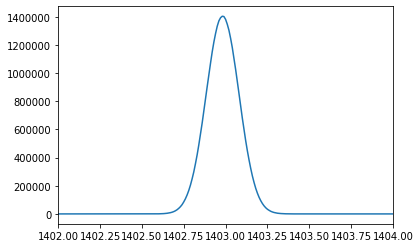

In [5]:
k = 125
arrs = siiv(tube,frac,log10T,log10G,time=k)
plt.plot(arrs.wav,arrs.spec)
plt.xlim(1402,1404)

In [6]:
ll = arrs.wav

In [7]:
arrs.rebin()

reshape index =  25
number of time elements after rebin:  16


Text(0.5, 0, 'wavelength [$\\AA$]')

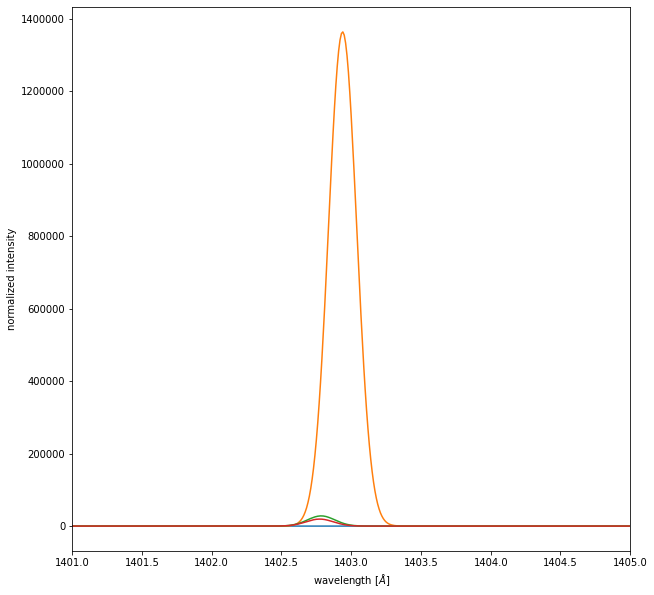

In [8]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,arrs.respec[0,:])
plt.plot(ll,arrs.respec[5,:])
plt.plot(ll,arrs.respec[10,:])
plt.plot(ll,arrs.respec[15,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [9]:
arrs.respec.shape

(16, 2000)

# Time series of synthetic spectrum:

In [14]:
arrs.fitspec()

nt =  16


(0, 50)

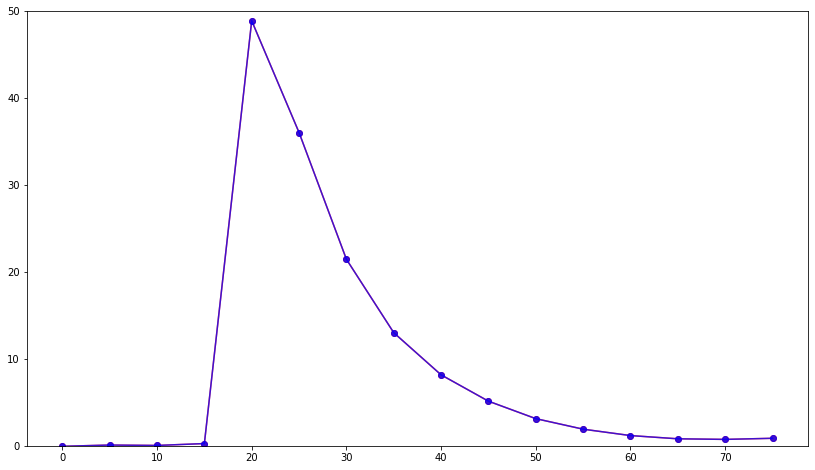

In [16]:
plt.figure(figsize=(14,8))
plt.plot(arrs.time,arrs.vr,'r',alpha=0.75,marker='o')
plt.plot(arrs.time,arrs.vb,'b',alpha=0.75,marker='o')
plt.ylim(0,50)

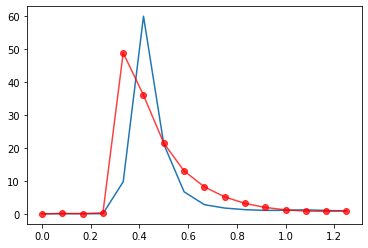

In [17]:
plt.plot(arrs.time/60,arrs.amp/np.max(arrs.amp)*60)
plt.plot(arrs.time/60,arrs.vr,'r',alpha=0.75,marker='o')

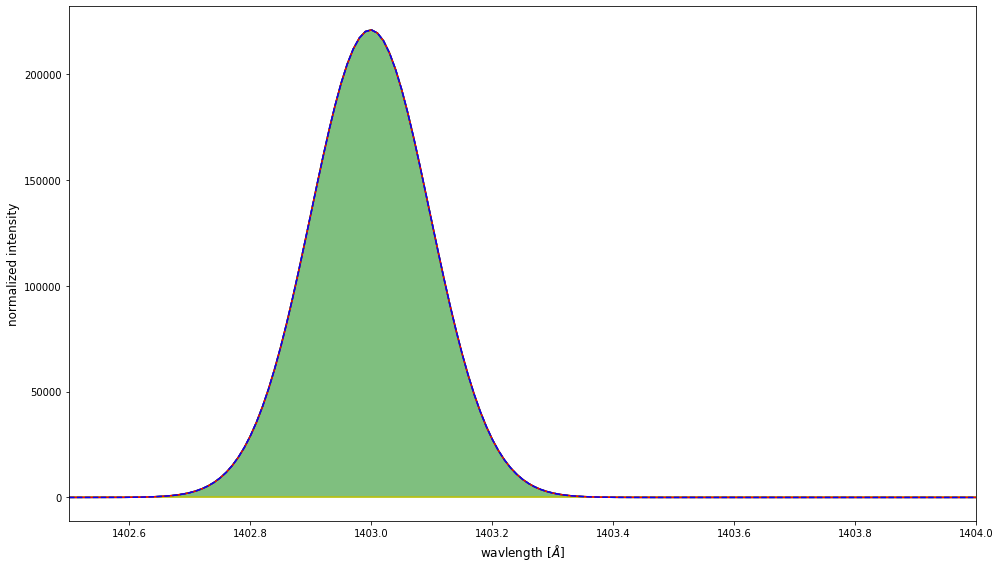

In [19]:
arrs.plotgauss(itime=4)

# Fit:

In [20]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [21]:
imax = np.argmax(arrs.vr) 

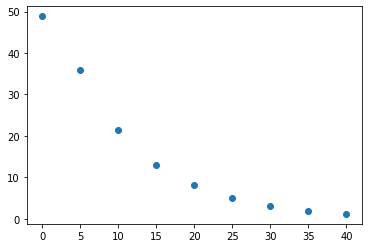

In [26]:
tt = arrs.time[imax:-3]
tt = tt-tt[0]
vr = arrs.vr[imax:-3]
plt.plot(tt,vr,'o')

In [27]:
a0= [arrs.vr[imax],15]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

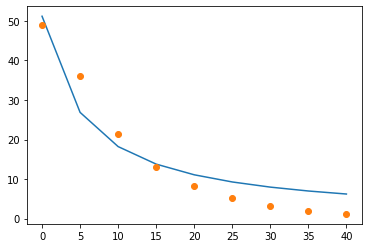

In [28]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')

In [29]:
popt[1]

5.521875701092703

In [30]:
H = 0.6*popt[0]*popt[1]

In [31]:
H

169.5849626812031